In [1]:
import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.qualitymetrics as sqm
import spikeinterface.widgets as sw

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os

%matplotlib inline

#######################################################################
animal_ID = '98'
session_ID = '2024-04-16T10-37-23'

base_folder = r"W:\projects\FlexiVexi\behavioural_data"
session_folder = os.path.join(base_folder, animal_ID, session_ID)
#######################################################################

# Path to raw binary file from Open Ephys within session folder
path_to_recording = r"W:\projects\FlexiVexi\behavioural_data\98\2024-04-16T10-37-23\Open-Ephys\98_2024-04-16_11-37-19"

# Path to Kilosort3 output files within session folder
kilosort_folder = os.path.join(session_folder, 'kilosort3')


c:\Users\megan\anaconda3\envs\spikeinterface\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Read in recording and spike sorting to create sorting analyser**

KiloSortSortingExtractor: 97 units - 1 segments - 30.0kHz


compute_waveforms: 100%|##########| 1717/1717 [01:54<00:00, 15.01it/s]


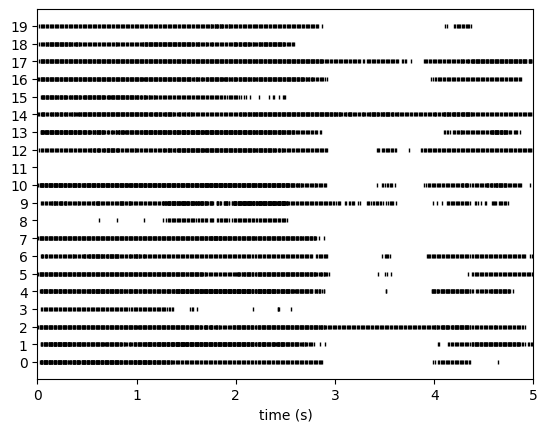

In [2]:
# Get output from spike sorting using Kilosort3
sorting_KS = se.read_kilosort(folder_path=kilosort_folder)
print(sorting_KS)

# Get recording from open ephys
recording = se.read_openephys(folder_path=path_to_recording, stream_name = 'Record Node 102#Neuropix-PXI-100.ProbeA')

# Create a sorting analyzer
sorting_analyzer = sc.create_sorting_analyzer(sorting_KS, recording)

# Compute sorting analyzer info
sorting_analyzer.compute("random_spikes")
sorting_analyzer.compute("waveforms")

# Plots rasters of first 20 units
w_rs = sw.plot_rasters(sorting_analyzer, time_range=(0, 5), unit_ids=list(range(20)))


**Get recording metadata**

Sampling frequency: 30000.0
Number of channels: 384
Number of segments: 1
Probe - 384ch - 4shanks


(<matplotlib.collections.PolyCollection at 0x21b7b17d400>,
 <matplotlib.collections.PolyCollection at 0x21b7b7ed3a0>)

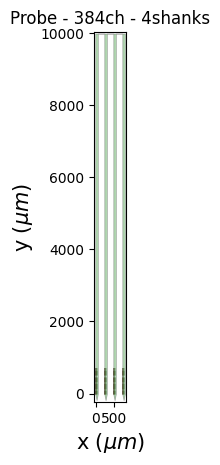

In [3]:
# Get basic meta-data from recording
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()

print("Sampling frequency:", fs)
print("Number of channels:", num_chan)
print("Number of segments:", num_seg)

probe = recording.get_probe()
print(probe)

from probeinterface.plotting import plot_probe

plot_probe(probe)


In [5]:
sorting_analyzer.compute("principal_components")
sorting_analyzer.get_extension('principal_components')

sorting_analyzer.get_extension('templates')

#print(sqm.get_quality_metric_list())
print(sqm.get_quality_pca_metric_list())

#get PCA scores
unit_id0 = sorting_analyzer.unit_ids[0]
#pca_scores = sorting_analyzer.get_extension("principal_components").get_data()[unit_id0]

#dir(sqm.pca_metrics)
pca_metrics = sqm.pca_metrics.calculate_pc_metrics(sorting_analyzer)
#sqm.pca_metrics.nearest_neighbors_isolation(sorting_analyzer, n_neighbors=4, this_unit_id=0)

Projecting waveforms: 100%|██████████| 97/97 [00:00<00:00, 97.60it/s] 


{'isolation_distance': {0: 117.11659518104392,
  1: 116.40163046566546,
  2: 114.35838412142455,
  3: 118.52177440214521,
  4: 117.58337926745918,
  5: 115.3849639582119,
  6: 138.07485741910145,
  7: 115.41621622191336,
  8: 119.53971946343844,
  9: 137.6629197461052,
  10: 117.01049910843528,
  11: 117.05133546459835,
  12: 114.93605229969195,
  13: 116.75873891734851,
  14: 171.02245343603903,
  15: 117.97172824431603,
  16: 118.31305648933886,
  17: 115.4012462588647,
  18: 118.27377825539044,
  19: 117.75552729587808,
  20: 115.58702912280862,
  21: 119.161472843165,
  22: 115.38481238206022,
  23: 118.27535468187786,
  24: 118.04631687799461,
  25: 171.69034055740235,
  26: 117.43743451877228,
  27: 142.30377781682026,
  28: 117.6735070805238,
  29: 139.38860257016324,
  30: 115.3269855107624,
  31: 116.58574141851395,
  32: 119.26580565688512,
  33: 117.39359133041182,
  34: 139.83024274836242,
  35: 119.82900515434203,
  36: 118.19250239933776,
  37: 114.3993620733711,
  38: 11

**Compute PCA and non-PCA metrics together**

In [8]:
sorting_analyzer.compute("templates")
sorting_analyzer.compute("noise_levels")

sorting_analyzer.compute("principal_components")
sorting_analyzer.get_extension('principal_components')

sorting_analyzer.get_extension('templates')

# depends on "waveforms", "templates", "noise_levels", and "pca")
sqm.compute_quality_metrics(sorting_analyzer, load_if_exists=None) 

#qm_ext = sorting_analyzer.compute(input={"pca": dict(n_components=5, mode="by_channel_local"),
 #                               "quality_metrics": dict(skip_pc_metrics=False)}) 
 # ^^ why does this produce an error message? should work based on https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html

C:\Users\megan\Documents\GitHub\spikeinterface\src\spikeinterface\qualitymetrics\misc_metrics.py:880: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
C:\Users\megan\Documents\GitHub\spikeinterface\src\spikeinterface\qualitymetrics\misc_metrics.py:724: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
C:\Users\megan\Documents\GitHub\spikeinterface\src\spikeinterface\qualitymetrics\misc_metrics.py:1457: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
calculate_pc_metrics: 100%|██████████| 97/97 [22:06<00:00, 13.67s/it]


,amplitude_cutoff,amplitude_cv,amplitude_median,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,rp_contamination,...,snr,sync_spike_2,sync_spike_4,sync_spike_8,d_prime,isolation_distance,l_ratio,silhouette,nn_hit_rate,nn_miss_rate
0,0.015647,NaN,-324.577484,34.78,10.464335,13.531220,7630.0,17962.0,1.000000,1.0,...,0.658308,0.004454,0.000000,0.000000,0.534994,117.116595,7.416368,-0.000191,0.000000,0.012577
1,0.008865,NaN,-339.885010,20.20,7.010207,1.877014,475.0,12033.0,1.000000,1.0,...,0.515242,0.000332,0.000166,0.000083,0.518431,116.401630,7.656640,0.000248,0.008264,0.013336
2,0.008634,NaN,-264.029999,14.20,4.838925,10.482987,1264.0,8306.0,1.000000,1.0,...,0.494508,0.000000,0.000000,0.000000,0.523906,114.358384,8.809641,0.000349,0.004132,0.010831
3,0.013140,NaN,-282.652466,24.96,6.933889,14.552787,3603.0,11902.0,1.000000,1.0,...,0.555495,0.000504,0.000252,0.000084,0.596852,118.521774,6.795051,-0.001089,0.006198,0.013665
4,0.013107,NaN,-327.599976,17.60,5.600359,23.360962,3773.0,9613.0,1.000000,1.0,...,0.575904,0.000312,0.000000,0.000000,0.499583,117.583379,7.288454,-0.001438,0.010331,0.013463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.006906,NaN,-378.787476,27.20,8.375196,14.808746,5349.0,14376.0,1.000000,1.0,...,0.553024,0.000000,0.000000,0.000000,0.563688,118.841117,6.322337,-0.000031,0.024793,0.013412
93,0.022074,NaN,-357.434998,15.92,3.884656,33.728548,2621.0,6668.0,1.000000,1.0,...,0.750831,0.000450,0.000150,0.000000,0.620616,119.997986,5.825112,-0.002186,0.002066,0.013286
94,0.013831,NaN,-297.959991,22.00,7.145949,16.706178,4393.0,12266.0,1.000000,1.0,...,0.496942,0.000245,0.000163,0.000000,0.628288,118.732718,6.428555,0.000526,0.016529,0.011362
95,0.013470,NaN,-288.697479,37.38,11.400544,13.575545,9086.0,19569.0,1.000000,1.0,...,0.471174,0.000051,0.000051,0.000000,0.544277,114.722310,8.545918,0.000289,0.010331,0.010831


**Analyse Units**

In [20]:
sorting_analyzer.compute("unit_locations", method="center_of_mass")

**Export sorting analyser to Phy**

In [ ]:
sexp.export_to_phy(sorting_analyzer, "phy", verbose=True)